### Version 07

In this version, we adjust alpha for ridge reg.
https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a
Regularization in Machine Learning
this technique discourages learning a more complex or flexible model, so as to avoid the risk of overfitting.
https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/
https://chrisalbon.com/code/machine_learning/linear_regression/selecting_best_alpha_value_in_ridge_regression/
https://www.mwbrady.com/post/ridgeregression/

In [2]:
# all imports and magic commands
import re
# import regex
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# text preprocessing
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from part_of_speech import get_part_of_speech

from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [8]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    reviews = movie_data.review
    lemmatizer = WordNetLemmatizer()
    porter_stemmer=PorterStemmer()
    CLEANR = re.compile('<.*?>') 
 #https://kavita-ganesan.com/how-to-use-countvectorizer/#.YjpnbprMIqw   
    def my_preprocessor(text):
        text=text.lower() 
        text=re.sub("\\W"," ",text) # remove special chars
        text=re.sub("\\s+(in|the|all|for|and|on)\\s+"," _connector_ ",text) # normalize certain words
    
    # stem words
    # words=re.split("\\s+",text)
    # stemmed_words=[porter_stemmer.stem(word=word) for word in words]

    # part_of_speech
    # lemmatization
        tokenized_string = word_tokenize(text)
        stemmed_words = [lemmatizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized_string]
        return ' '.join(stemmed_words)

    print(movie_data.head(10))
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = CountVectorizer(ngram_range=(1,2), preprocessor=my_preprocessor)
        X_hv = hv.fit_transform(reviews)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(reviews)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    movie_data['word_count'] = reviews.str.split(' ').str.len()
    movie_data['punc_count'] = reviews.str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../data/moviereviews_train.tsv', my_random_seed=73)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

        id  sentiment                                             review
0   5814_8          1  With all this stuff going down at the moment w...
1   2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2   7759_3          0  The film starts with a manager (Nicholas Bell)...
3   3630_4          0  It must be assumed that those who praised this...
4   9495_8          1  Superbly trashy and wondrously unpretentious 8...
5   8196_8          1  I dont know why people think this is such a ba...
6   7166_2          0  This movie could have been very good, but come...
7  10633_1          0  I watched this video at a friend's house. I'm ...
8    319_1          0  A friend of mine bought this film for £1, and ...
9  8713_10          1  <br /><br />This movie is full of references. ...
movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review  

# Fit (and tune) Various Models

#### Ridge Regression by Alpha Steps
https://www.mwbrady.com/post/ridgeregression/

In [5]:
from sklearn import linear_model

alphas = []
rdgs = []
rdg_trainings = []

for alpha in range(0,30000,500):
    rdg = linear_model.RidgeClassifier(alpha=alpha)
    alphas.append(alpha)
    rdgs.append(rdg)

for rdg in rdgs:
    rdg.fit(X_train, y_train)
    rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, f"a-{alpha}")
    rdg_performance_train.compute_measures()
    rdg_trainings.append(rdg_performance_train)

for training in rdg_trainings:
    print(training.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'a-29500'}
{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'a-29500'}
{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'a-29500'}
{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'a-29500'}
{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'a-29500'}
{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'a-29500'}
{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'a-29500'}
{'Pos'

### ROC plot to compare performance of various models and fits

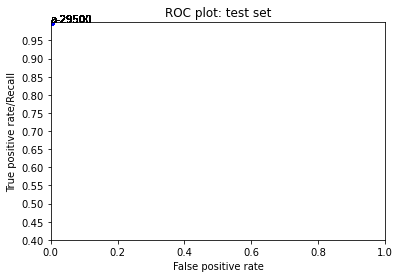

In [8]:
fits = rdg_trainings
    
fig = plt.subplots(figsize=(6, 4))

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0.4, 1])
plt.yticks(np.arange(0.4, 1, 0.05))
plt.title('ROC plot: test set')
plt.ylabel('True positive rate/Recall')
plt.xlabel('False positive rate')
plt.show()

### Create Pivot Table

In [9]:
fits = rdg_trainings

TP_rate =[]
FP_rate =[]

rows = []

for alpha in range(0,30000,500):
    rows.append(f"a-{alpha}")

for fit in fits:
    FP_rate.append(fit.performance_measures['FP'] / fit.performance_measures['Neg'])
    TP_rate.append(fit.performance_measures['TP'] / fit.performance_measures['Pos'])
    
df = pd.DataFrame({"True Positive Rate":TP_rate, "False Positive Rate": FP_rate, "Rows": rows})
train_table = pd.pivot_table(df, values=["True Positive Rate","False Positive Rate"], index=["Rows"]).sort_values(by=['True Positive Rate'],ascending=False)

column_order=["True Positive Rate","False Positive Rate"]
train_table = train_table.reindex(column_order, axis=1)

print(train_table)

         True Positive Rate  False Positive Rate
Rows                                            
a-0                     1.0                  0.0
a-1000                  1.0                  0.0
a-24000                 1.0                  0.0
a-24500                 1.0                  0.0
a-2500                  1.0                  0.0
a-25000                 1.0                  0.0
a-25500                 1.0                  0.0
a-26000                 1.0                  0.0
a-26500                 1.0                  0.0
a-27000                 1.0                  0.0
a-27500                 1.0                  0.0
a-28000                 1.0                  0.0
a-28500                 1.0                  0.0
a-29000                 1.0                  0.0
a-29500                 1.0                  0.0
a-3000                  1.0                  0.0
a-3500                  1.0                  0.0
a-4000                  1.0                  0.0
a-4500              

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [71]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [61]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
7
Kol, space prisoner on space death row, manages to hijack a space shuttle and escape to the woods of America where he, along with some new found friend try to escape from the 'Alienator\ a female cyborg killing machine. Made one year after the best movie of Fred Olen Ray's career, \"Hollywood Chainsaw Hookers\", this one can't help but feel like a bit of a letdown. Just as low-budget as that earlier film, but not nearly as fun as I had with it. None of the actors really stood out at me. The film is alright for the undiscriminating viewer during a rainy Saturday afternoon, but that's pretty much all it's good for.<br /><br />My Grade: D+ <br /><br />Where i saw it: Showtime Thriller"
* * * * * * * * * 
10
Oh my goodness. This was a real big mess that just couldn't help itself. Jeffrey (Jon Heder) is a 29 year old man still living with his mum (Diane Keaton) and not planning on going anywhere. Until his mother meets a rich businessman named Mert (Jeff Danie

909
This movie makes a promising start and then gets very confused and muddled. Kamal Hasan has made a lot of effort in getting the period look right, pity he did not spend more time on the plot. Most of the small characters in the movie show up for no particular reason.<br /><br />Overall very disappointing, I would recommend avoiding this movie.
* * * * * * * * * 
953
DARK REMAINS is a low budget American horror movie that somehow managed to win 2 awards.<br /><br />The plot seems to involve 2 separate strands. First, a woman commits suicide by slashing her wrists whilst bathing. Second, the young daughter of a technical writer is found with her throat slashed. The grieving couple decide to move to an isolated cabin in the mountains. It later transpires that the cabin and surrounding locations are haunted.<br /><br />As the movie goes on, the 2 separate strands of story eventually converge as one might reasonably expect. However, the execution is haphazard and results in confusion th

1881
People, please don't bother to watch this movie! This movie is bad! It's totally waste of time. I don't see any point here. It's a Stupid film with lousy plot and the acting is poor. I rather get myself beaten than watch this movie ever again.
* * * * * * * * * 
1920
Music that grinds on the nerves like fingernails on a blackboard, acting that is so zombielike it was a shame to waste the cast by not making a second movie; casting everyone in it as true zombies---with the cast of Sabrina the Teenaged Witch as the heroes... a movie so downright awful that if \stoners\" were still around it might be considered a cult movie---but, oh so amateurish, the scripts might as well have been carried around by the actors, their lines read as they slowly shuffled through the movie---banal, illogical sets modeled after LA subdivisions, props straight from ToysRus! Was a movie ever made that is so completely and totally inept??? Logic flies to the wind in this plodding, senseless, pointless and w

3182
Now, I like sci-fi cartoons. However, when \Robotboy\" appeared in Canada in late 2006, I watched the premiere and was inevitably appalled. The characters are generic and stereotypical (Do they REALLY need to make an African-American man wear tiger-stripe print clothing and speak in a Jamacian accent? WHY are all the Asian characters vibrant yellow and squinting? Does the mother HAVE to have big thighs and chest and constantly complain?) to the point where things become unrealistic, predictable, gross and sometimes disturbing. There are heavy similarities to, even stabs, at Astro Boy. Allow me to explain (dub names for the young): Robotboy/Astro, Kamikaze/Tenma, Constantine/Shadow, Gus/Abercrombie, Tommy/Alejo, Lola/Zoran+Kennedy, Moshimo/O'Shay, and it so on. Brief resemblances to \"My Life As A Teenage Robot\", \"Star Wars\", \"Teenage Mutant Ninja Turtles\", \"Kamen Riders\", \"Sailor Moon\" and co. are afoot. Not to mention the abundant racial/gender stereotyping. Don't even g

4396
Deep Shock plays out like a TV movie: a whole cast of commercial-quality actors, a poorly designed creature to be the \bad guy,\" and a script that is more full of technical, political jargon and importances than it knows what to do with.<br /><br />I checked out the movie because of the creature (I love to see what filmmakers have in mind for their designs in these cheaply made videos), and right off the bat, I got disappointed because the creature on the box was not the one in the movie. The actors I expected because of the type of film it is (really quite generic and not thought out past a certain point). The music was typical, not-thought-out action symphonic music.<br /><br />I liked the design of the computers and technical equipment, along with the mini-sub design. The movie even flowed really well, with guiding screens letting you know which set you're watching the story unfold in. But there isn't much of a story here anyways.<br /><br />This movie gets a 3/10 stars IMO. T

5879
This movie is now my gauge against which all other movies will be compared...as in, \was it as stupid as Revolver?\" I too was in the Toronto International Film Festival audience last night where a room filled with over 2000 people walked out in an eerie silence after being absolutely dumbstruck by 2 hours of sheer nonsense. Jason Stratham would have been amazing if only he had a purpose. Within the first 10 minutes he's given a proposition by Andre 3000 and Big Pussy (of Soprano's fame) which makes NO SENSE AT ALL! Then there's some shooting and then there's Ray Liotta wearing embarrassing bikini briefs, then there's some animation, Ray Liotta's naked butt, lots of shooting, teeth gnashing, art house wanna be pretensions and more of Liotta's embarrassing body that elicited laughs at every showing...which I'm not quite sure was the reaction he was looking for...not 5 times anyway. Everyone in this movie thinks they're smarter than the average bear and Guy Ritchie thinks he's Yogi 

7909
I want to state first that I am a Christian (and that I do work in the film and TV industry) so I understand what it is like to work on a feature length film so props to the filmmakers in that regard. I'm all for positive, uplifting messages if they are true to the nature of life (that this is a fallen world and that things don't always work out ... even for followers of Christ). I'm glad that others are having such overwhelmingly positive reactions to the overt Christian message; for me it was just that the execution is where the film fell on its face. A movie lives and dies on its story and here you have one dimensional stereotypes, exposition aplenty, and spontaneous changes in character behavior that are inexplicably to say the least. I believe that a film does not have to club you over the head with its message to get the point across. I'm sure the Kendrick bros. will improve with time and that their storytelling methods will as well. Maybe they could direct someone else's sc

10149
THE CRIMSON RIVERS is one of the most over-directed, over-the-top, over-everything mess I've ever seen come out of France. There's nothing worse than a French production trying to out-do films made in Hollywood and CR is a perfect example of such a wannabe horror/action/buddy flick. I almost stopped it halfway through because I knew it wouldn't amount to anything but French guys trying to show-off.<br /><br />The film starts off promisingly, like some sort of expansive horror film, but it quickly shifts genres, from horror to action to x-files type to buddy flick, that in the end, CR is all of it and also none of it. It's so full of clichés that at one point I thought the whole thing was a comedy. The painful dialogue and those silent pauses, with fades outs and fades ins just at the right expositionary moments, made me groan. I thought only films made in Hollywood used this hackneyed technique.<br /><br />The chase scene, with Vincent Cassel running after the killer, is so over-

12164
A lot of death happens in the wild. You don't need to be a rocket scientist to figure that out! But does it need to be the focus of a nature documentary? What is with this fascination with gruesome death? Do we really have to see an adult elephant torn to shreds by a pack of hungry lions? Or, a cheetah grabbing a gazelle by the throat in slow motion, no less! I thought this was going to be a family-friendly nature film! <br /><br />And, why not have the courage to show the gruesome violence in the film's trailers? Were the filmmakers afraid of losing money?<br /><br />Then in typical, comic relief fashion we get to see the magnificent Birds-of-Paradise perform mating rituals to the most annoying and stupid narration humanly possible. It was surreal! It's as if the filmmakers believed they were only addressing a roomful of First and Second graders on a school field trip! Wow! From the mean to the moronic in a heartbeat!<br /><br />If there are any future nature documentary filmmak

14314
(BIG SPOILERS) I've seen one other Takashi Miike film, and that was the very disturbing and brutal 'Audition', which was an examination of the Japanese ideals of femininity! In 'Visitor Q'- which I think means 'Visitor Question'- he examines, in a very disturbingly gross way, the family unit. Miike's surreal vision of a dysfunctional family almost tries to be Lynchian in terms of confusion and film-making, but ultimately lacks the style and intrigue. We, the audience, are introduced to a bizarre array of scenarios from the opening scene with the father figure (Kenichi Endo- who was actually quite good) paying for sex with his displaced daughter (Fujiko). Then, as the father returns home, he is struck on the head by \the visitor\" (Kazushi Watanabe) wielding a fairly sizeable rock, and for some reason, they both end up back at the family home. The mother (Shungiku Uchida) is beaten and bullied by her son (Jun Muto) who is also beaten and bullied by his school peers. When the visit

16273
Original Claymation Rudolph: Pretty good. Original Frosty cartoon: Needs a little work, but could be worse. But Frosty and Rudolph together on the Fourth of July? C'mon! Give me a BREAK!!! This was one movie that shouldn't have been made. It was bad. It didn't really go for any holiday in particular, except July 4. That made it especially bad since Frosty and Rudolph are usually associated with the Christmas season. And any movie can be ruined by too much singing. The frequent songs made this movie seem a lot longer than it really was. The movie tried mixing two familiar Chirstmastime characters with an American traditional holiday (which almost seems to \limit\" it to America), too many pointless songs, and a lousy plotline. The result? A bad movie that can't really be watched at any time of year. I would suggest you forgo this movie even if you like Frosty and Rudolph."
* * * * * * * * * 
16347
Watching this movie was the biggest waste of time and 2 bucks for rental in my life.

18364
This was filmed back-to-back with the 1992 re-make of Conan Doyle's famous novel 'The Lost World'. And it shows.<br /><br />The film starts promisingly enough, with a ruthless organization intending to exploit the lost world and Challenger et al returning to defend the prehistoric plateau, but then things go downhill. Everybody is stranded on the plateau and we're left with a feeble, boring, over-length rehash of the first film.<br /><br />The dinosaurs (who are hardly ever seen) are just laughable. Are we expected to take that cuddly toy that's supposed to be an ankylosaur seriously? And the tyrannosaur seems rooted to the spot.<br /><br />Do yourself a favor and get hold of the 1925 silent version of the Lost World. Unbelievably in this age of CGI and other advanced effects, the twenties version is the best and will remain so until somebody finally decides to do a decent re-make.
* * * * * * * * * 
18386
Another of my delves into the bargain bin, this movie gave me exactly what

19961
This move reminded my of Tales from the Crypt Keeper. It has the same sort of idea of people get what they deserve. I think that's always the them in a Crypt story. The same goes for the bad acting. Very bad acting. I enjoyed the movie knowing that most people didn't like it and I wasn't expecting much. Whenever I watch a stephen King movie I don't expect much because all his movies are awful compared to the genius of his novels. I have read The Shining and Carrie and they were great books. I love how Carrie played out like it was a true story and the whole book is a bunch of reports and theories and such. It was so good. But I noticed that both of the novels were nothing like the movies. The endings were very different then the movie versions. I assume from those two novels that all of his novels are changed greatly and the endings are always cheesy. I ending of Thinner is the worst. So Cheesy. I want to read the book to find out the real ending. I suggest everyone who intends t

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: Ridge Regression by Alpha Steps

In [10]:
rdg_tests = []
alpha = 0;

for rdg in rdgs:
    alpha +=500
    rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, f"a-{alpha}-test")
    rdg_performance_test.compute_measures()
    rdg_tests.append(rdg_performance_test)
    
for test in rdg_tests:
    print(test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 2310, 'TN': 2171, 'FP': 329, 'FN': 190, 'Accuracy': 0.8962, 'Precision': 0.8753315649867374, 'Recall': 0.924, 'desc': 'a-500-test'}
{'Pos': 2500, 'Neg': 2500, 'TP': 2310, 'TN': 2171, 'FP': 329, 'FN': 190, 'Accuracy': 0.8962, 'Precision': 0.8753315649867374, 'Recall': 0.924, 'desc': 'a-1000-test'}
{'Pos': 2500, 'Neg': 2500, 'TP': 2311, 'TN': 2171, 'FP': 329, 'FN': 189, 'Accuracy': 0.8964, 'Precision': 0.8753787878787879, 'Recall': 0.9244, 'desc': 'a-1500-test'}
{'Pos': 2500, 'Neg': 2500, 'TP': 2311, 'TN': 2171, 'FP': 329, 'FN': 189, 'Accuracy': 0.8964, 'Precision': 0.8753787878787879, 'Recall': 0.9244, 'desc': 'a-2000-test'}
{'Pos': 2500, 'Neg': 2500, 'TP': 2310, 'TN': 2173, 'FP': 327, 'FN': 190, 'Accuracy': 0.8966, 'Precision': 0.875995449374289, 'Recall': 0.924, 'desc': 'a-2500-test'}
{'Pos': 2500, 'Neg': 2500, 'TP': 2310, 'TN': 2172, 'FP': 328, 'FN': 190, 'Accuracy': 0.8964, 'Precision': 0.8756633813495072, 'Recall': 0.924, 'desc': 'a-3000-test'}
{'Po

### ROC plot to compare performance of various models and fits

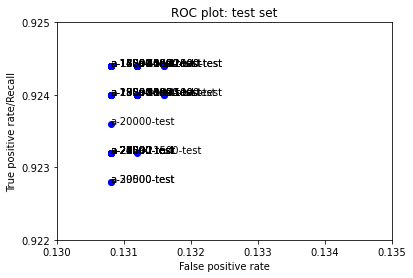

In [14]:
fits = rdg_tests
fig = plt.subplots(figsize=(6, 4))

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0.13, 0.135, 0.922, 0.925])
plt.yticks(np.arange(0.922, 0.925, 0.001))
plt.xticks(np.arange(0.13, 0.135, 0.001))
plt.title('ROC plot: test set')
plt.ylabel('True positive rate/Recall')
plt.xlabel('False positive rate')
plt.show()

### Create Pivot Table

In [116]:
fits = rdg_tests

TP_rate =[]
FP_rate =[]

rows = []
for alpha in range(0,30000,500):
    rows.append(f"a-{alpha}")
    
for fit in fits:
    FP_rate.append(fit.performance_measures['FP'] / fit.performance_measures['Neg'])
    TP_rate.append(fit.performance_measures['TP'] / fit.performance_measures['Pos'])
    
df = pd.DataFrame({"True Positive Rate":TP_rate, "False Positive Rate": FP_rate, "Rows": rows})
test_table = pd.pivot_table(df, values=["True Positive Rate","False Positive Rate"], index=["Rows"]).sort_values(by=['True Positive Rate'],ascending=False)

column_order=["True Positive Rate","False Positive Rate"]
test_table = test_table.reindex(column_order, axis=1)

print(test_table)

         True Positive Rate  False Positive Rate
Rows                                            
a-16000              0.9244               0.1308
a-5000               0.9244               0.1312
a-6000               0.9244               0.1312
a-6500               0.9244               0.1312
a-4500               0.9244               0.1312
a-4000               0.9244               0.1312
a-16500              0.9244               0.1308
a-1000               0.9244               0.1316
a-15500              0.9244               0.1308
a-15000              0.9244               0.1308
a-3500               0.9244               0.1312
a-14500              0.9244               0.1308
a-14000              0.9244               0.1308
a-13500              0.9244               0.1308
a-13000              0.9244               0.1308
a-12500              0.9244               0.1308
a-12000              0.9244               0.1308
a-11500              0.9244               0.1312
a-11000             

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/home/ec2-user/data/moviereviews_test.tsv', my_random_seed=74, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Size

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.5596


In [25]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [26]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,1
2,5828_4,1
3,7186_2,1
4,12128_7,0


In [27]:
my_submission.shape

(25000, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/home/ec2-user/data/moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation